In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import h5py
from scipy.optimize import curve_fit

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [4]:
def get_psd(h5_file_path='results/5-10-vahemman-rpoints/partial/l-32-d-4/shapes.h5',noise_key=None):
    psds = list()
    
    f = h5py.File(h5_file_path, "r")
    print(f.keys())

    if type(noise_key) == type(None):
        noise_key = list(f.keys())[0]

    for seed in f[noise_key].keys():
        dataset = f[noise_key][seed]

        heights = dataset[-1]
        force = dataset.attrs['tau_exts'][-1]

        if len(heights.shape) > 1: # this means that it's a partial dislocation and we want to compute the cm.
            heights = np.mean(heights, axis=0)

        k = np.fft.fft(heights)
        fq = np.fft.fftfreq(len(k))

        psd = np.abs(k**2)
        psds.append(psd)
    
    psds = np.array(psds)
    psd = np.mean(psds, axis=0)
    return psd

In [ ]:
from scipy.stats import linregress

def plot_psd_with_fit(ax, h5_file, noise_key, label, fit_range=(0, 50), color=None):
    """
    Gets PSD data, plots it, performs a linear regression on a log-log scale,
    and plots the fit.
    
    """
    start, end = fit_range

    psd = get_psd(h5_file, noise_key=noise_key)
    
    # Plot PSD
    line, = ax.plot(psd[start:end], label=label, color=color)
    # Get the color of the line plot to use for the fit
    plot_color = line.get_color()

    x = np.arange(len(psd))
    
    # Define the range for the fit
    x_fit = x[start:end]
    y_fit = psd[start:end]

    # Perform linear regression, avoiding log(0) by starting from index 1
    if len(x_fit) > 1 and len(y_fit) > 1:
        # Use indices where x_fit and y_fit are positive
        valid_indices = (x_fit > 0) & (y_fit > 0)
        
        if np.sum(valid_indices) > 1:
            log_x = np.log(x_fit[valid_indices])
            log_y = np.log(y_fit[valid_indices])
            
            slope, intercept, r_value, p_value, std_err = linregress(log_x, log_y)

            # Print the results
            # print(f"--- Fit for {label} ---")
            # print(f"Slope: {slope:.2f}")
            # print(f"R-squared: {r_value**2:.2f}")

            # Create and plot the line of best fit
            y_fit_line = np.exp(intercept) * x_fit**slope
            ax.plot(x_fit, y_fit_line, '--', color=plot_color, label=f'Fit ({label}): {slope:.2f}')
        else:
            print(f"Not enough data points for a fit for {label}.")
    else:
        print(f"Not enough data points for a fit for {label}.")

<KeysViewHDF5 ['0.0001', '0.0001930697728883', '0.0003727593720314', '0.0007196856730011', '0.0013894954943731', '0.0026826957952797', '0.0051794746792312', '0.01', '0.0193069772888324', '0.0372759372031493', '0.0719685673001151', '0.1389495494373137', '0.2682695795279725', '0.5179474679231207', '1.0']>
<KeysViewHDF5 ['0.0001', '0.0001930697728883', '0.0003727593720314', '0.0007196856730011', '0.0013894954943731', '0.0026826957952797', '0.0051794746792312', '0.01', '0.0193069772888324', '0.0372759372031493', '0.0719685673001151', '0.1389495494373137', '0.2682695795279725', '0.5179474679231207', '1.0']>
<KeysViewHDF5 ['0.0001', '0.0001930697728883', '0.0003727593720314', '0.0007196856730011', '0.0013894954943731', '0.0026826957952797', '0.0051794746792312', '0.01', '0.0193069772888324', '0.0372759372031493', '0.0719685673001151', '0.1389495494373137', '0.2682695795279725', '0.5179474679231207', '1.0']>
<KeysViewHDF5 ['0.0001', '0.0001930697728883', '0.0003727593720314', '0.0007196856730

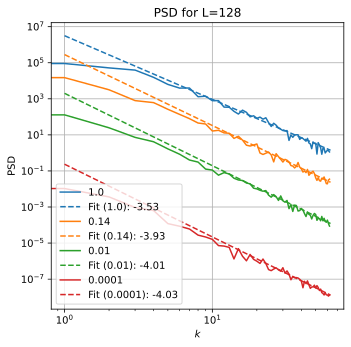

In [33]:
fig, ax = plt.subplots(figsize=(5,5))

h5_file = "../results/11-10-pieni-c_gamma/perfect/l-128/shapes.h5"

plot_psd_with_fit(ax, h5_file, noise_key='1.0', label="1.0", fit_range=(1,64))
plot_psd_with_fit(ax, h5_file, noise_key='0.1389495494373137', label="0.14", fit_range=(1,64))
plot_psd_with_fit(ax, h5_file, noise_key='0.01', label="0.01", fit_range=(1,64))
plot_psd_with_fit(ax, h5_file, noise_key='0.0001', label="0.0001", fit_range=(1,64))


ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlabel('$k$')
ax.set_ylabel('PSD')

ax.set_title('PSD for L=128')

fig.tight_layout()
ax.legend()
ax.grid(True)

<KeysViewHDF5 ['0.0001', '0.0001930697728883', '0.0003727593720314', '0.0007196856730011', '0.0013894954943731', '0.0026826957952797', '0.0051794746792312', '0.01', '0.0193069772888324', '0.0372759372031493', '0.0719685673001151', '0.1389495494373137', '0.2682695795279725', '0.5179474679231207', '1.0']>
<KeysViewHDF5 ['0.0001', '0.0001930697728883', '0.0003727593720314', '0.0007196856730011', '0.0013894954943731', '0.0026826957952797', '0.0051794746792312', '0.01', '0.0193069772888324', '0.0372759372031493', '0.0719685673001151', '0.1389495494373137', '0.2682695795279725', '0.5179474679231207', '1.0']>
<KeysViewHDF5 ['0.0001', '0.0001930697728883', '0.0003727593720314', '0.0007196856730011', '0.0013894954943731', '0.0026826957952797', '0.0051794746792312', '0.01', '0.0193069772888324', '0.0372759372031493', '0.0719685673001151', '0.1389495494373137', '0.2682695795279725', '0.5179474679231207', '1.0']>
<KeysViewHDF5 ['0.0001', '0.0001930697728883', '0.0003727593720314', '0.0007196856730

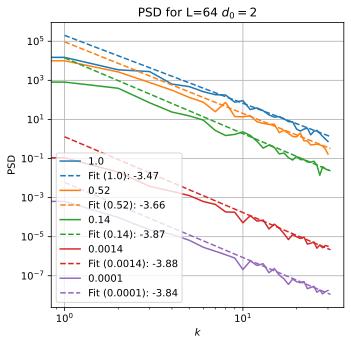

In [34]:
fig, ax = plt.subplots(figsize=(5,5))

h5_file = "../results/11-10-pieni-c_gamma/partial/l-64-d-2/shapes.h5"


plot_psd_with_fit(ax, h5_file, noise_key='1.0', label="1.0", fit_range=(1,32))
plot_psd_with_fit(ax, h5_file, noise_key='0.5179474679231207', label="0.52", fit_range=(1,32))
plot_psd_with_fit(ax, h5_file, noise_key='0.1389495494373137', label="0.14", fit_range=(1,32))
plot_psd_with_fit(ax, h5_file, noise_key='0.0013894954943731', label="0.0014", fit_range=(1,32))
plot_psd_with_fit(ax, h5_file, noise_key='0.0001', label="0.0001", fit_range=(1,32))

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlabel('$k$')
ax.set_ylabel('PSD')

ax.set_title('PSD for L=64 $d_0 = 2$')

fig.tight_layout()
ax.legend()
ax.grid(True)

<KeysViewHDF5 ['0.0001', '0.0001930697728883', '0.0003727593720314', '0.0007196856730011', '0.0013894954943731', '0.0026826957952797', '0.0051794746792312', '0.01', '0.0193069772888324', '0.0372759372031493', '0.0719685673001151', '0.1389495494373137', '0.2682695795279725', '0.5179474679231207', '1.0']>
<KeysViewHDF5 ['0.0001', '0.0001930697728883', '0.0003727593720314', '0.0007196856730011', '0.0013894954943731', '0.0026826957952797', '0.0051794746792312', '0.01', '0.0193069772888324', '0.0372759372031493', '0.0719685673001151', '0.1389495494373137', '0.2682695795279725', '0.5179474679231207', '1.0']>
<KeysViewHDF5 ['0.0001', '0.0001930697728883', '0.0003727593720314', '0.0007196856730011', '0.0013894954943731', '0.0026826957952797', '0.0051794746792312', '0.01', '0.0193069772888324', '0.0372759372031493', '0.0719685673001151', '0.1389495494373137', '0.2682695795279725', '0.5179474679231207', '1.0']>
<KeysViewHDF5 ['0.0001', '0.0001930697728883', '0.0003727593720314', '0.0007196856730

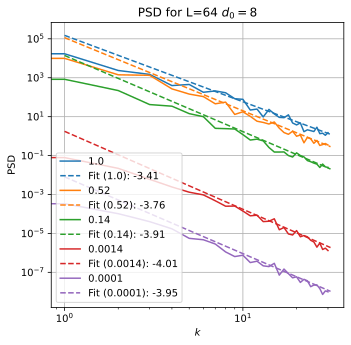

In [23]:
fig, ax = plt.subplots(figsize=(5,5))

h5_file = "../results/11-10-pieni-c_gamma/partial/l-64-d-8/shapes.h5"


plot_psd_with_fit(ax, h5_file, noise_key='1.0', label="1.0", fit_range=(1,32))
plot_psd_with_fit(ax, h5_file, noise_key='0.5179474679231207', label="0.52", fit_range=(1,32))
plot_psd_with_fit(ax, h5_file, noise_key='0.1389495494373137', label="0.14", fit_range=(1,32))
plot_psd_with_fit(ax, h5_file, noise_key='0.0013894954943731', label="0.0014", fit_range=(1,32))
plot_psd_with_fit(ax, h5_file, noise_key='0.0001', label="0.0001", fit_range=(1,32))


ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlabel('$k$')
ax.set_ylabel('PSD')

ax.set_title('PSD for L=64 $d_0 = 8$')

fig.tight_layout()
ax.legend()
ax.grid(True)

<KeysViewHDF5 ['0.0001', '0.0001930697728883', '0.0003727593720314', '0.0007196856730011', '0.0013894954943731', '0.0026826957952797', '0.0051794746792312', '0.01', '0.0193069772888324', '0.0372759372031493', '0.0719685673001151', '0.1389495494373137', '0.2682695795279725', '0.5179474679231207', '1.0']>
<KeysViewHDF5 ['0.0001', '0.0001930697728883', '0.0003727593720314', '0.0007196856730011', '0.0013894954943731', '0.0026826957952797', '0.0051794746792312', '0.01', '0.0193069772888324', '0.0372759372031493', '0.0719685673001151', '0.1389495494373137', '0.2682695795279725', '0.5179474679231207', '1.0']>
<KeysViewHDF5 ['0.0001', '0.0001930697728883', '0.0003727593720314', '0.0007196856730011', '0.0013894954943731', '0.0026826957952797', '0.0051794746792312', '0.01', '0.0193069772888324', '0.0372759372031493', '0.0719685673001151', '0.1389495494373137', '0.2682695795279725', '0.5179474679231207', '1.0']>
<KeysViewHDF5 ['0.0001', '0.0001930697728883', '0.0003727593720314', '0.0007196856730

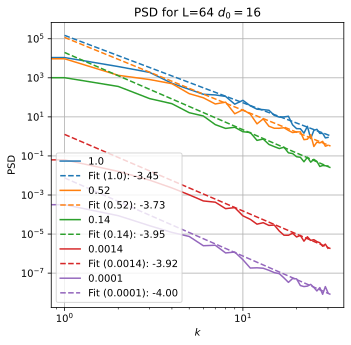

In [35]:
fig, ax = plt.subplots(figsize=(5,5))

h5_file = "../results/11-10-pieni-c_gamma/partial/l-64-d-16/shapes.h5"


plot_psd_with_fit(ax, h5_file, noise_key='1.0', label="1.0", fit_range=(1,32))
plot_psd_with_fit(ax, h5_file, noise_key='0.5179474679231207', label="0.52", fit_range=(1,32))
plot_psd_with_fit(ax, h5_file, noise_key='0.1389495494373137', label="0.14", fit_range=(1,32))
plot_psd_with_fit(ax, h5_file, noise_key='0.0013894954943731', label="0.0014", fit_range=(1,32))
plot_psd_with_fit(ax, h5_file, noise_key='0.0001', label="0.0001", fit_range=(1,32))


ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlabel('$k$')
ax.set_ylabel('PSD')

ax.set_title('PSD for L=64 $d_0 = 16$')

fig.tight_layout()
ax.legend()
ax.grid(True)

<KeysViewHDF5 ['0.0001', '0.0001930697728883', '0.0003727593720314', '0.0007196856730011', '0.0013894954943731', '0.0026826957952797', '0.0051794746792312', '0.01', '0.0193069772888324', '0.0372759372031493', '0.0719685673001151', '0.1389495494373137', '0.2682695795279725', '0.5179474679231207', '1.0']>
<KeysViewHDF5 ['0.0001', '0.0001930697728883', '0.0003727593720314', '0.0007196856730011', '0.0013894954943731', '0.0026826957952797', '0.0051794746792312', '0.01', '0.0193069772888324', '0.0372759372031493', '0.0719685673001151', '0.1389495494373137', '0.2682695795279725', '0.5179474679231207', '1.0']>
<KeysViewHDF5 ['0.0001', '0.0001930697728883', '0.0003727593720314', '0.0007196856730011', '0.0013894954943731', '0.0026826957952797', '0.0051794746792312', '0.01', '0.0193069772888324', '0.0372759372031493', '0.0719685673001151', '0.1389495494373137', '0.2682695795279725', '0.5179474679231207', '1.0']>
<KeysViewHDF5 ['0.0001', '0.0001930697728883', '0.0003727593720314', '0.0007196856730

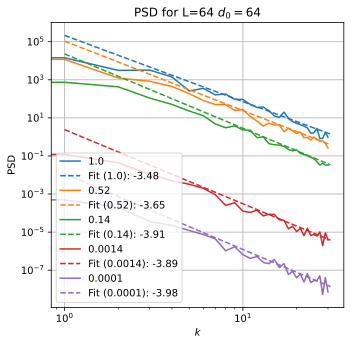

In [36]:
fig, ax = plt.subplots(figsize=(5,5))

h5_file = "../results/11-10-pieni-c_gamma/partial/l-64-d-64/shapes.h5"


plot_psd_with_fit(ax, h5_file, noise_key='1.0', label="1.0", fit_range=(1,32))
plot_psd_with_fit(ax, h5_file, noise_key='0.5179474679231207', label="0.52", fit_range=(1,32))
plot_psd_with_fit(ax, h5_file, noise_key='0.1389495494373137', label="0.14", fit_range=(1,32))
plot_psd_with_fit(ax, h5_file, noise_key='0.0013894954943731', label="0.0014", fit_range=(1,32))
plot_psd_with_fit(ax, h5_file, noise_key='0.0001', label="0.0001", fit_range=(1,32))


ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlabel('$k$')
ax.set_ylabel('PSD')

ax.set_title('PSD for L=64 $d_0 = 64$')

fig.tight_layout()
ax.legend()
ax.grid(True)